In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio as rio
import geopandas as gp

import fiona 
import rasterio
import rasterio.mask

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from matplotlib.lines import Line2D
from matplotlib.ticker import StrMethodFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from sklearn import metrics

from osgeo import gdal, osr, ogr
from tqdm import tqdm
from scipy import stats, spatial, signal, fftpack
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

In [2]:
gdf = gp.read_file("../shape/sierra_catchments.shp")

In [3]:
def write_raster(array,gdf,outfn):
	'''
	converts a numpy array and a geopandas gdf to a geotiff
	Data values are stored in np.array
	spatial coordinates stored in gdf
	outfn - outpath
	'''
	
	xmin, ymin = gdf.bounds.minx.values[0], gdf.bounds.miny.values[0]
	xmax, ymax = gdf.bounds.maxx.values[0], gdf.bounds.maxy.values[0]
	nrows, ncols = array.shape
	xres = (xmax-xmin)/float(ncols)
	yres = (ymax-ymin)/float(nrows)
	geotransform =(xmin,xres,0,ymax,0, -yres)   

	output_raster = gdal.GetDriverByName('GTiff').Create(outfn,ncols, nrows, 1 , gdal.GDT_Float32)  # Open the file
	output_raster.SetGeoTransform(geotransform)  # Specify coords
	srs = osr.SpatialReference()                 # Establish encoding
	srs.ImportFromEPSG(4326)                     # WGS84 lat long
	output_raster.SetProjection(srs.ExportToWkt() )   # Export coordinate system 
	output_raster.GetRasterBand(1).WriteArray(array)   # Write array to raster
	
	print("wrote {}".format(outfn))
	return outfn

def get_fnf(stn_id):
    '''
    Query CA DWR website to get reservoir storage for an area of interest
    '''
    print("**** Fetching FNF for {} ****".format(stn_id))

    url = "https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=8&dur_code=D&Start=2000-09-01&End=2021-09-01".format(stn_id)
    df = pd.read_csv(url)

    df[stid] = pd.to_numeric(df['VALUE'], errors='coerce').interpolate(how = 'linear') * 0.0283168 # cfs --> cms 
    df.index = pd.to_datetime(df['DATE TIME'])
    df.index.names = ['date']
    df.drop(['STATION_ID', "VALUE", "DURATION", "SENSOR_NUMBER", 
             "SENSOR_TYPE", "OBS DATE",'DATE TIME', "DATA_FLAG", "UNITS"], axis = 1, inplace = True)

    df[df[stid] < 0] = np.nan
    return df#.interpolate(how = 'polynomial', order = 3)

In [4]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))


def normalize(x):
	return(x-np.nanmin(x))/(np.nanmax(x)- np.nanmin(x))

def standardize(x):
    scaled = (x - np.nanmean(x)) / np.nanstd(x);
    scaled[np.isnan(x)] = 0
    return scaled

def calc_xcorr(imstack, qarr, K):
    
    imgmean = np.nanmean(imstack, axis=2)
    b = qarr.copy()
    
    rows, cols, time = imstack.shape
    px_ts = []
    rclist = []
    
    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            
            ts_arr = imstack[row, col, :]
            
            # NaN check 
            if np.isnan(imgmean[row, col]):
                continue
            ts_arr[np.isnan(ts_arr)] = 0
            px_ts.append(pd.Series(ts_arr))
            rclist.append([row, col])
    
    pxdf = pd.concat(px_ts, axis=1)
    pxdf.columns = pxdf.columns.map(str)
    
    # Build the out image - guaranteed same dimensions as input slice
    corrim = np.full_like(np.mean(imstack, axis=2), np.nan)
    
    # Populate the per-pixel lags 
    for rc, dfcolidx in tqdm(list(zip(rclist, pxdf.columns))):
        a = pxdf[dfcolidx].values
        days_window = int(K / 2) 
        offset_range = range(-int(days_window + 1), int(days_window + 1))
        rs = [crosscorr(pd.Series(a), pd.Series(b), lag) for lag in offset_range]
        offset = range(0, len(offset_range))[np.argmax(rs)]
        
        # fill ims
        rowidx, colidx = rc
        corrim[rowidx, colidx] = rs[np.argmax(rs)]
        
    return corrim


In [5]:
def main(stid):
    
    # Read table 1
    t1df = pd.read_csv("../data/Table1.csv")
    t1df.drop(columns=t1df.columns[0], axis=1, inplace=True)

    # Read rainfall and snowmelt data
    smlt_fn_1d = "../data/Watersheds/smlt/{}_smlt.npy".format(stid)
    prcp_fn_1d = "../data/Watersheds/prcp/{}_prcp.npy".format(stid)

    # Read runoff
    bf = pd.read_csv("../data/baseflow_sep/baseflow_mm.csv")
    bf['date'] = pd.to_datetime(bf['date'])
    bf.set_index("date", inplace = True)    
    sr = pd.read_csv("../data/baseflow_sep/surface_runoff_mm.csv") 
    sr['date'] = pd.to_datetime(sr['date'])
    sr.set_index("date", inplace = True)   

    # Load files as np arrays
    smlt = np.load(smlt_fn_1d)
    smlt = smlt*100 # apply scaling factor 
    prcp = np.load(prcp_fn_1d)

    qarr = bf[stid].values

    K = 180 # Set time tolerance 
        
    outdir = "../results/BF_xc_K180"
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    # write if doesn't exist, read if it does 
    if not os.path.exists(os.path.join(outdir,"{}_prcp.tif".format(stid))):
        pr_corr = calc_xcorr(prcp, qarr, K)
        write_raster(pr_corr, gp.read_file("../shape/{}.shp".format(stid)), os.path.join(outdir,"{}_prcp.tif".format(stid)))
    else:
        pr_corr = rio.open(os.path.join(outdir,"{}_prcp.tif".format(stid))).read(1)

    # write if doesn't exist, read if it does 
    if not os.path.exists(os.path.join(outdir,"{}_smlt.tif".format(stid))):
        sm_corr = calc_xcorr(smlt, qarr, K)
        write_raster(sm_corr, gp.read_file("../shape/{}.shp".format(stid)), os.path.join(outdir,"{}_smlt.tif".format(stid)))
    else:
        sm_corr = rio.open(os.path.join(outdir,"{}_smlt.tif".format(stid))).read(1)
    
    # plot 
    plt.figure(figsize = (15,5))
    plt.subplot(121)
    plt.imshow(pr_corr); plt.colorbar()
    plt.subplot(122)
    plt.imshow(sm_corr); plt.colorbar()
    plt.show()

SJF


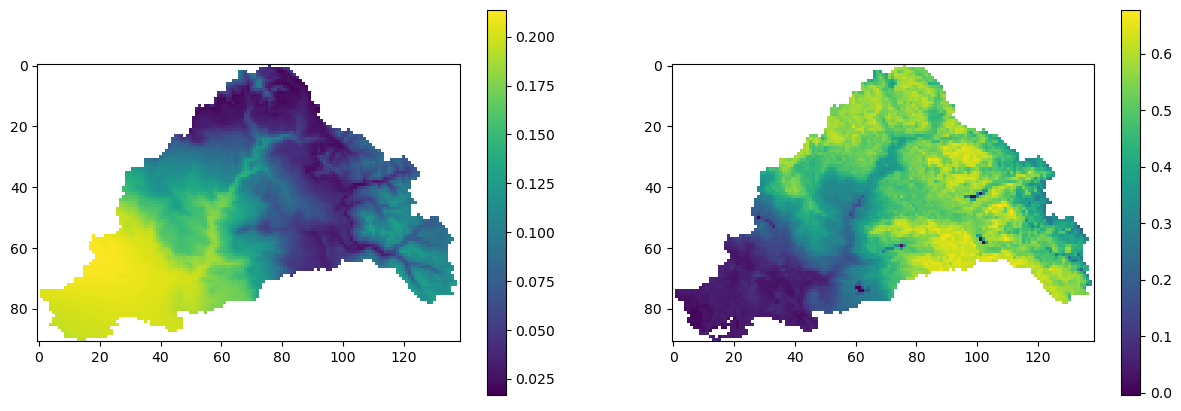

TLG


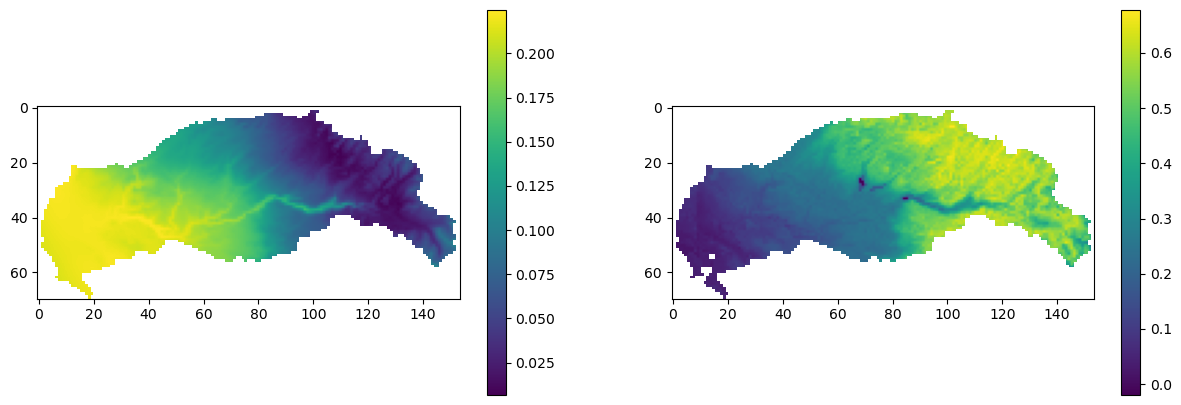

ISB


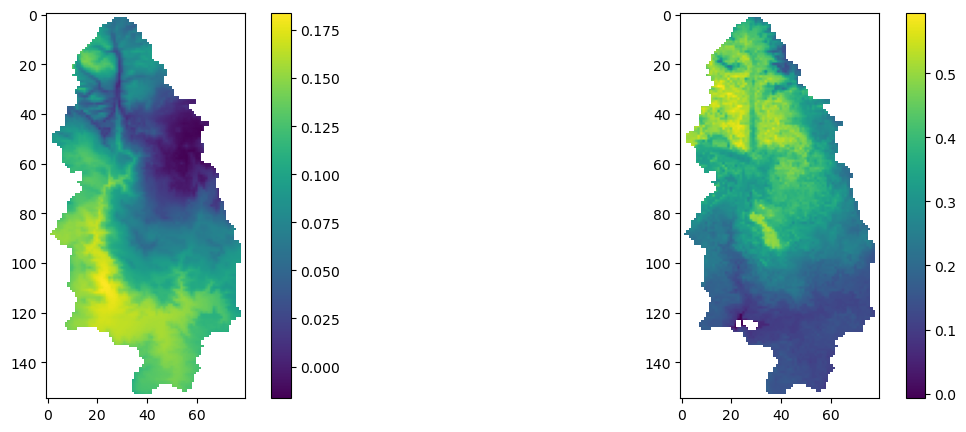

NAT


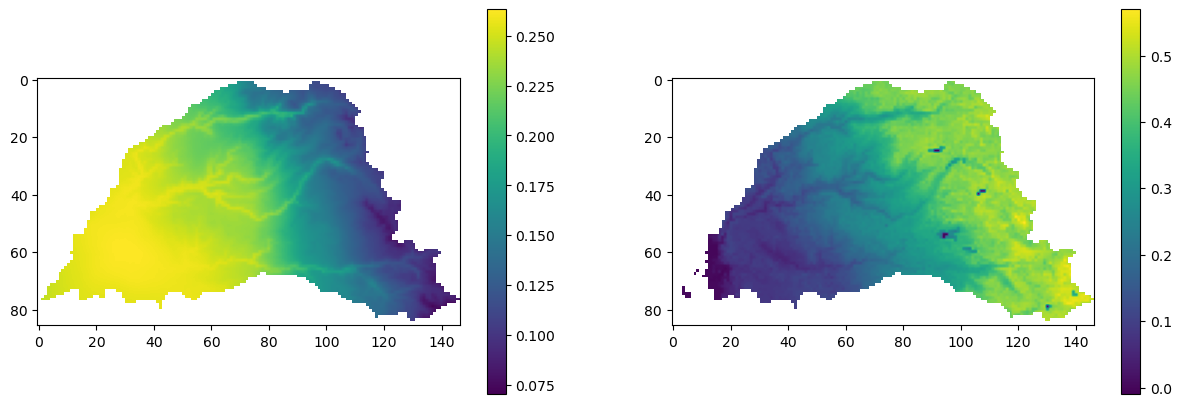

MHB


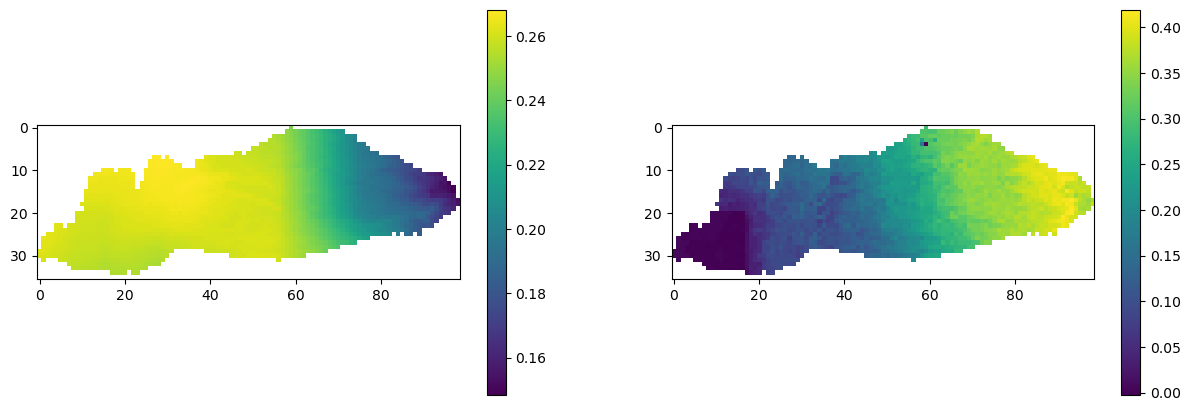

NML


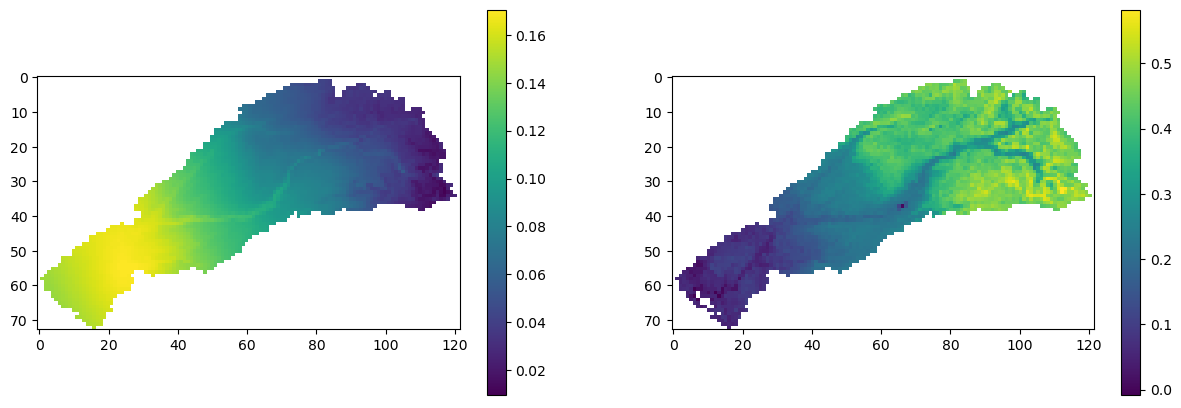

ORO


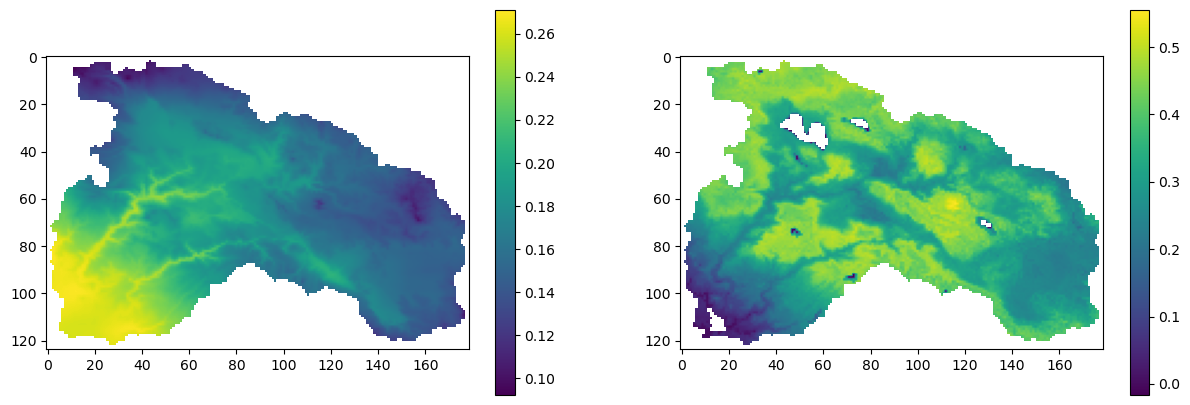

TRM


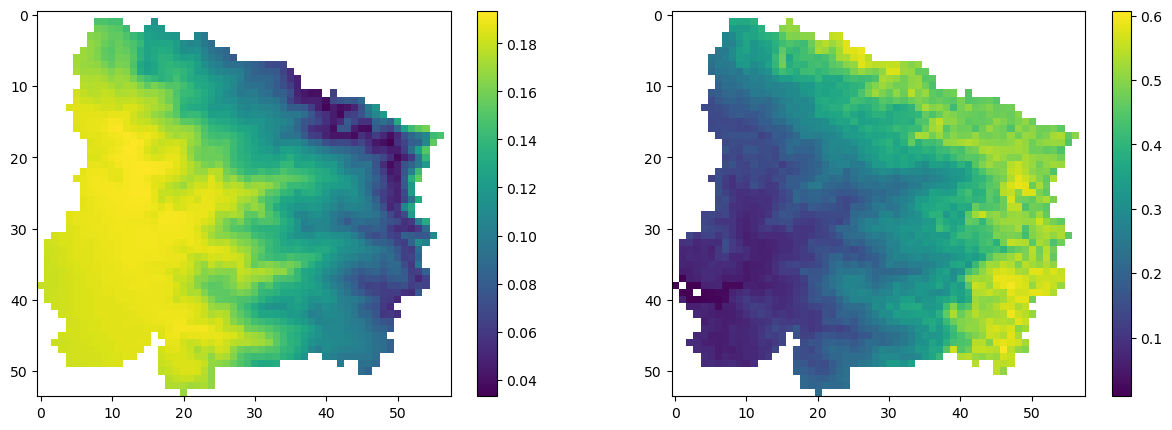

MKM


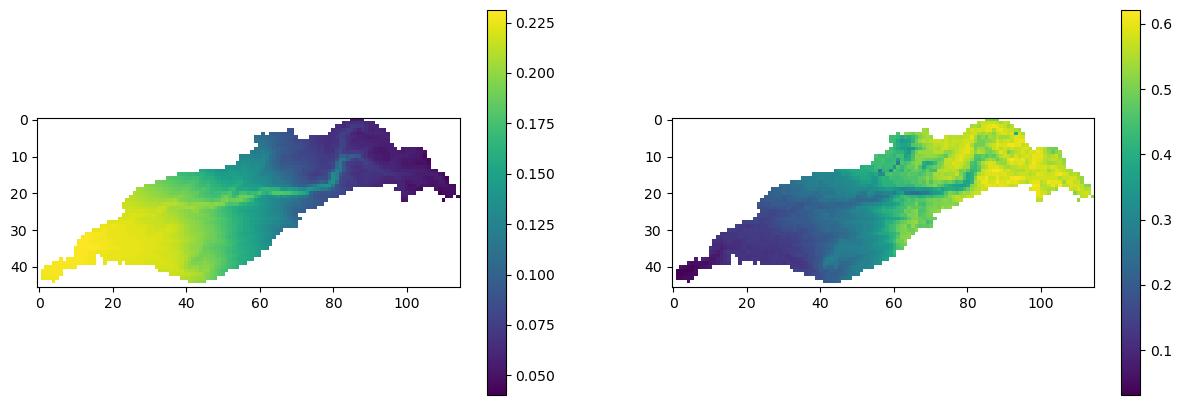

SCC


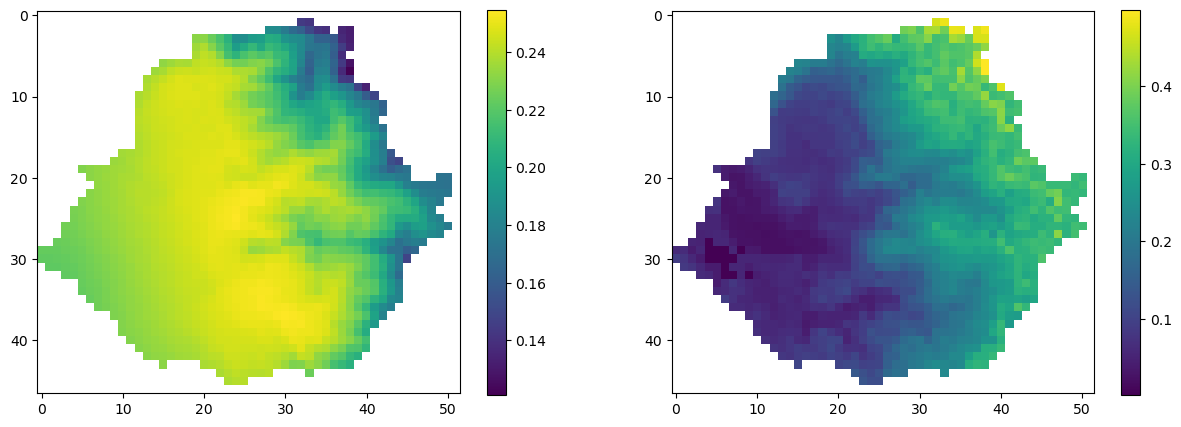

PNF


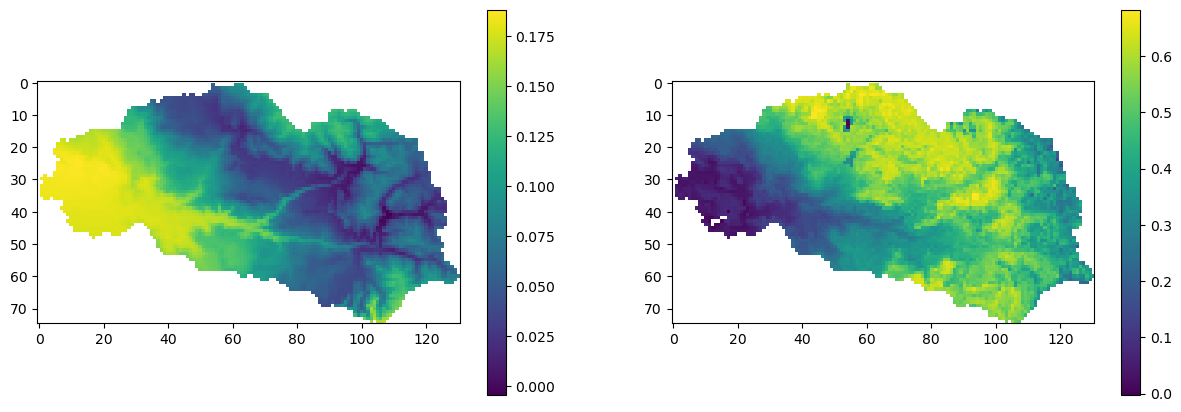

EXC


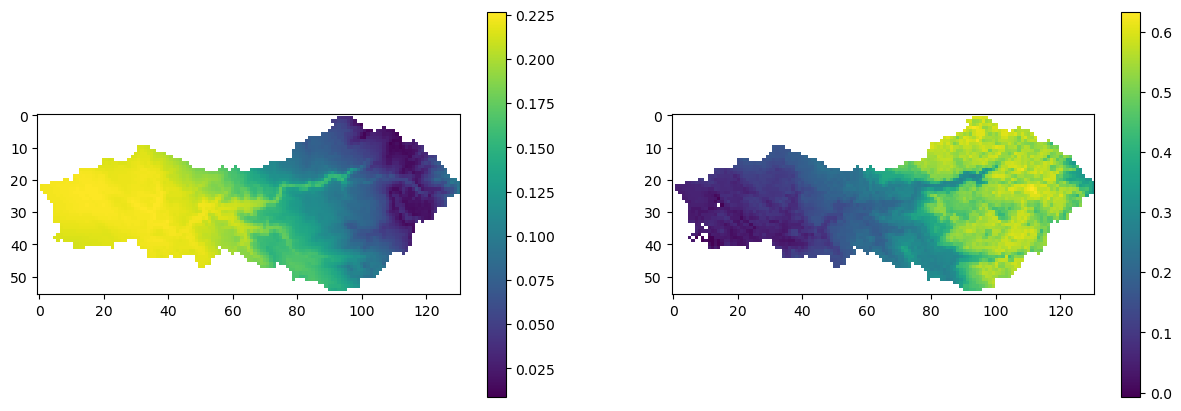

NHG


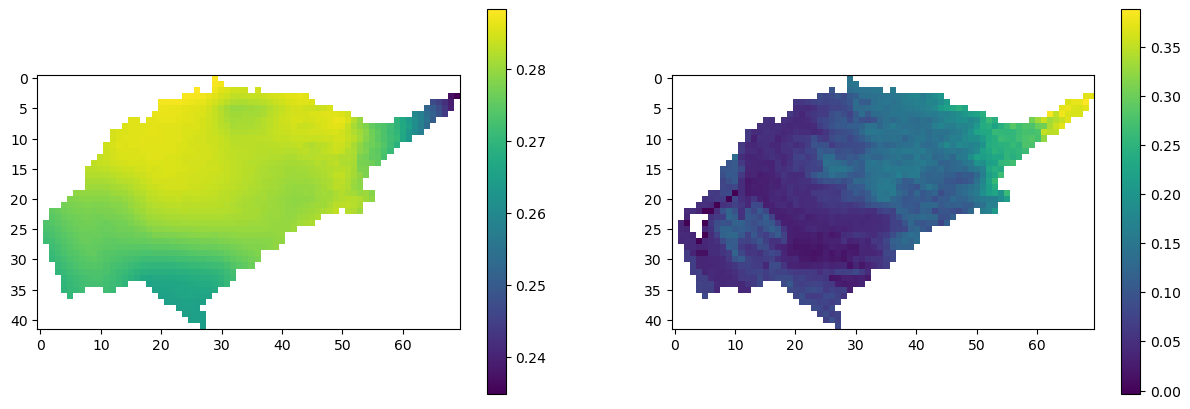

YRS


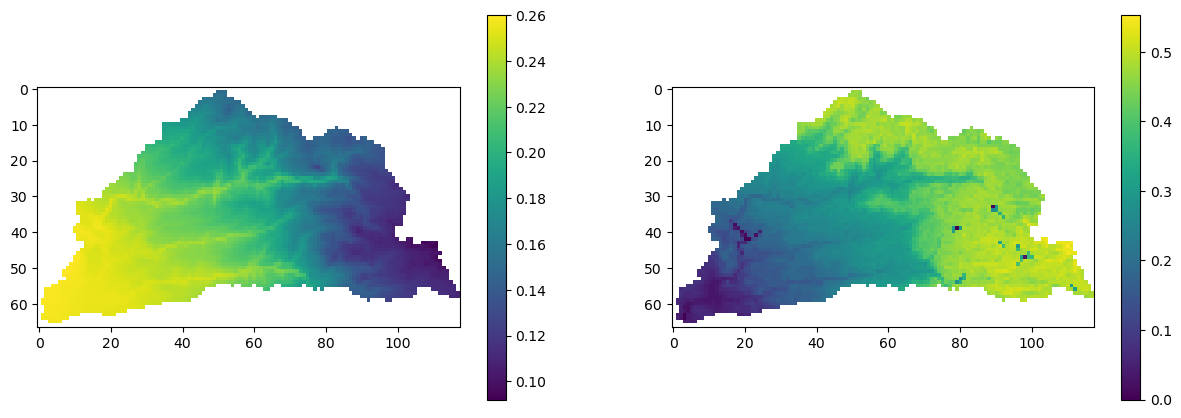

SHA


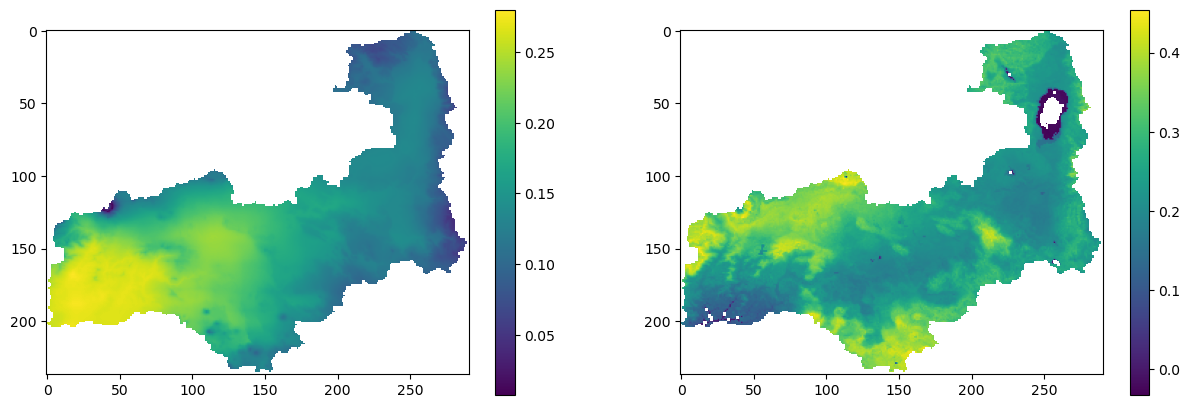

In [6]:
for stid in list(gdf['stid'][:]):
    print("{}".format(stid))
    main(stid)